In [1]:
import numpy as np
import h5py
import os 
import json
import scipy.io as spio
import matplotlib.pyplot as plt 
import pickle
from matplotlib.mlab import PCA
from scipy.stats.distributions import chi2
from numpy import matlib


# This is a python implementation of 

# Jin et al. (2015), Adaptive reference updating for vibration-based
# structural health monitoring under varying environmental conditions,
# Computers & Structures.

In [2]:
def hotelling_tsquared(pc):
    """`pc` should be the object returned by matplotlib.mlab.PCA()."""
    x = pc.a.T
    cov = pc.Wt.T.dot(np.diag(pc.s)).dot(pc.Wt) / (x.shape[1] - 1)
    w = np.linalg.solve(cov, x)
    t2 = (x * w).sum(axis=0)
    return t2

def Standardization_Data(X0,mu0,sds0,numobs,SD_type):
    import numpy as np 
    
    if SD_type == 'Mean_centered': return (X0 - np.matlib.repmat(mu0,numobs,1));
    elif SD_type == 'Z-score': return np.divide((X0 - np.matlib.repmat(mu0,numobs,1)),  np.matlib.repmat(sds0,numobs,1)) 
    
def disteusq(x,y,mode = '0', w = None): 
    #  VOICEBOX home page: http://www.ee.ic.ac.uk/hp/staff/dmb/voicebox/voicebox.html

    nx, p = x.shape     
    ny = y.shape[0]
    
    if mode=='d' or ( (mode !='x') and (nx==ny)): 
        nx=np.min((nx,ny))
        z = x[0:nx,:]-y[0:nx,:]
        if not w : 
            return np.sum(np.multiply(z, np.conj(z)),1)
        elif np.min(w.shape) == 1:
            if w.shape[0] > w.shape[1] : 
                wv = w.T 
            else : 
                wv = w
                return np.sum(np.multiply(np.multiply(z, matlib.repmat(wv, wv.shape[1], 1)), np.conj(z)), 1).T;
        else : 
            return np.sum(np.multiply(np.matmul(z, w), np.conj(z)), 1)

    else : 
        if p > 1 : 
            if not w : 
                if y.ndim == 1 : 
                    z = np.transpose(x[ ..., None], (0, 2, 1)) - np.transpose(np.repeat(y[ None,...], nx, axis = 0)[None, ...], (1, 0, 2))
                    return np.sum(np.multiply(z, np.conj(z)), 2)
                elif y.ndim == 2 : 
                    z = np.repeat(x[None, ...], ny, axis = 0) - np.transpose(np.repeat(y[ None,...], nx, axis = 0), (1, 0, 2))
                    return np.sum(np.multiply(z, np.conj(z)), 2).T

def k_means(d,k,x = []) :

    n, p = d.shape
    
    if len(x) == 0: 
        x = d[int(np.floor(np.random.rand(1, k)*n)), :].copy()

    y = x + 1
    ite = 0

    while np.sum(x != y) > 0 :
        
        ite = ite + 1
        
        z = disteusq(d, x, 'x')
        m, j = np.min(z, axis = 1), np.argmin(z, axis = 1)
        
        
        y = x.copy()
        if x.ndim == 1 : x = np.reshape(x, (1, p))

        for i in range(0, k) : 
            s = j==i
            if np.sum(s) > 0 : 

                x[i, :] = np.mean(d[s,:], axis = 0)
                if x.shape[0] == 1 or x.shape[1] == 1 : 
                    x = np.reshape(x, (p, ))
            else :
                q = np.argwhere(m!=0)
                if np.sum(q) > 0 : break
                r = q[int(np.floor(np.random.rand()*len(q)))][0].copy()
                x[i, :] = d[r, :].copy()
                m[r] = 0 
                y = x + 1

    esq = np.mean(m,0)

    return x, esq, j

def kmeanlbg(d, k) : 
    
    nc = d.shape[1]
    x, esq, j = k_means(d, 1)
    m = 1 
    ite = 0
    x = np.reshape(x, (1, x.shape[0]))
    while m < k : 
        ite = ite + 1 
        n = np.min((m, k-m))
        m = m + n
        e = float("1e-4")*np.sqrt(esq)*np.random.rand(1, nc)
        e_ = np.tile(e, (n, 1))
        
        x_ = []
        x_ = np.vstack((x[0:n,:]+e_, x[0:n,:]-e_))
        x_ = np.vstack((x_, x[n:m-n,:]))
        
        x, esq, j = k_means(d, m, x = x_)
    
    return x, esq, j

def Bayes_Information_Criterion(X,idx,ctrs):
    
    n, d = X.shape
    m = ctrs.shape[0]    
    BIC=0;
    
    for i in range(0, m) :
        index_i = np.argwhere(idx==i) # index of i-th clustering
        Xi = X[index_i,:] # sample of the i-th cluster
        ni = Xi.shape[0] # number of samples in the i-th index
        mi = np.mean(Xi, 0) # mean of the i-th cluster

        if ni > m : 

            sigma_i=1/(ni-m)*np.sum((np.sum(np.square(Xi- matlib.repmat(mi, ni, 1))[:, 0, :],1)), 0)
            BIC = BIC+ni*np.log(ni/n)-ni*d/2*np.log(2*np.pi)-ni/2*np.log(sigma_i)-(ni-m)/2        
    BIC = BIC-m*np.log(n)/2
    
    return BIC

def variable_window_length_by_kmeansLBG(X1,PC,SD_type): 
    
    k = PC['k_cluster']

    if X1['f0'].shape[0] > X1['L_max'] : 
        X1['f0']=X1['f0'][-int(X1['L'][-1][0]):,:]

    numobs = X1['f0'].shape[0]
    X = Standardization_Data(X1['f0'],X1['mu0'][-1,:],X1['sds0'][-1,:],numobs,SD_type)
    
    IDX = np.asarray([])
    CENTROID = np.asarray([])
    F = np.asarray([])
    BIC = np.asarray([])
    
    for i in range(0,k.shape[0]) :
        if k[i]==0:
            ctrs, esq, idx = kmeanlbg(X, k[i])
            IDX = idx[..., None].copy()
            CENTROID = np.append(CENTROID, ctrs )
            BIC = np.append(BIC, Bayes_Information_Criterion(X,idx,ctrs) ) 
            
        else:
            ctrs,esq,idx = kmeanlbg(X, k[i])
            IDX = np.column_stack((IDX, idx[..., None]))
            CENTROID = np.append(CENTROID, ctrs )
            BIC = np.append(BIC, Bayes_Information_Criterion(X,idx,ctrs) ) 
            
    A, ind = np.max(BIC), np.argmax(BIC, 0) 
    
    if IDX.ndim == 1 : IDX = np.reshape(IDX, (1, IDX.shape[0]))        

    idx = IDX[:,ind]
    n_cluster = k[ind]
    
    if n_cluster == 1 : 
        L = np.argwhere(idx == idx[-1]).shape[0]
        
    else : 
        L = np.argwhere(idx == idx[-1]).shape[0]
    
    try:
        X1['N_cluster']=np.vstack((X1['N_cluster'], n_cluster))
    except :
        X1['N_cluster']=n_cluster
    
    try:
        X1['BIC'] = np.vstack((X1['BIC'], BIC))
    except  :
        X1['BIC'] = BIC
    
    X1['L'] = np.vstack((X1['L'], L))
    

    if X1['L0'][0]: 
        X1['L0'] = np.vstack((X1['L0'], X1['L'][-1]))
            
    return X1 

def VMWPCA_update(X0,PC,Q,alpha,SD_type,ind_x,ind): 
    
    f, mu0, sds0 = X0['f'], X0['mu0'], X0['sds0']
    loadings, n_pc, variances = PC['loadings'], PC['n_pc'], PC['variances']
    
    if n_pc.ndim == 0:
        n_pc =  n_pc[..., None]
        n_pc =  n_pc[..., None]
    elif n_pc.ndim == 1:     
        n_pc =  n_pc[..., None]
        
    
    Qdist , distcrit = Q['Qdist'].copy(), Q['distcrit'].copy()

    ## Standardization (zero-mean)
    numobs1 = 1
    numvars = f.shape[1]
    X1std = Standardization_Data(f[-1,:], mu0[-1,:], sds0[-1,:], numobs1, SD_type);
    
    ## PC_PROJECTION
    if int(n_pc[-1,:]) == 0 : load_id = 1
    else : load_id = int(n_pc[-1,:])
    
    scores1 = np.matmul(X1std, loadings[:, :load_id ])
    
    residuals_val = X1std - np.matmul(scores1[:,:load_id ],loadings[:,:load_id].T)
    
    Qdist_val = np.sqrt(np.divide(np.sum(np.square(residuals_val),1), (numvars-2)));
    Qdist = np.hstack((Qdist, Qdist_val))

    ## CHECK ANOMALITY
    Q_lim=distcrit[-int(PC['n_stall']):]
    Q_check=Q['Qdist'][-int(PC['n_stall']):] <= Q_lim[:, 0]

    # Ref) 2006_Adaptive Multivariate Statistical Process Control for Monitoring Time-varying Process_ind.Eng.Chem.Res.
    # If three consecutive out-of-control samples have been generated, the new
    # sample is not outlier and it is a sample in abnormal condition.
    # Otherwise, it is an outlier.
    # Check whether current sample is in control or out of control
    
    if Q_check[-1] == 0:
        # outlier or fault? Anyway dont update current PC
        Normal_condition=0
        try:
            PC['fault']=np.vstack((PC['fault'], PC['fault'][-1]+1)) # To be updated 
        except :
            PC['fault'] = [1]
        
    else :
        Normal_condition=1
        try:
            PC['fault']=np.vstack((PC['fault'], 0)) # To be updated 
        except :
            PC['fault'] = [0]

    ## Perform update for PC model based novelty evaluation
    # If fault is detected. stop PCA update
    if PC['fault'][-1] > PC['n_stall'] :
        PC['update'] = 0 

    if PC['update']:
        if Normal_condition == 1 : 
            X0['f0']= np.vstack((X0['f0'], f[-1,:]))
            
            # ESTIAMTE THE WINDOW SIZE FOR ADPATIVE PROCESSING            
            X0 = variable_window_length_by_kmeansLBG(X0,PC,SD_type)
            
            # Discard the initial sample of the current window
            f = X0['f0'][-int(X1['L'][-1][0]):,:].copy() 
            n = f.shape[0]
            
            # UPDATE MEAN (mu0) and SIGMA (sds0)
            
            mu0 = np.vstack((mu0, np.mean(f, axis = 0)))
            sds0 = np.vstack((sds0, np.std(f, axis = 0)))
            numobs = f.shape[0]
            
            # Standardization
            X0std=Standardization_Data(f,mu0[-1,:],sds0[-1,:],numobs,SD_type);
            # UPDATE PC MODEL
            pc = PCA(X0std, standardize=True)
            loadings = pc.Wt.T
            loadings = -loadings.copy()
            loadings[:, 0] = -loadings[:, 0 ]
            cov = loadings.dot(np.diag(pc.s)).dot(pc.Wt) / (loadings.shape[0] - 1)
            scores = pc.Y
            variances = np.sort(np.linalg.eig(cov)[0])[::-1]
            tscores = hotelling_tsquared(pc)
            
            # Extracting the retained PC  => Eq. (9) in Ref. (SHM, 2018)
            Y, IX = np.max(abs(np.diff(variances))), np.argmax(abs(np.diff(variances)))
            n_pc = np.vstack((n_pc, IX))
            
            # Calculate Q-statistics
            
            ## These two lines required to broadcast scores and loadings into 2D array
            if int(n_pc[-1,:]) == 0 : load_id = 1
            else : load_id = int(n_pc[-1,:])
            scores_ = scores[:,0:load_id]
            loadings_ = loadings[:,0:load_id].T
            residuals = X0std - np.matmul(scores_,loadings_)
            Qdist1 = np.sqrt(np.sum(np.square(residuals), 1))
            m_Q=np.mean(Qdist1)
            V_Q=np.var(Qdist1)
            V=2*(m_Q**2)/V_Q
            distcrit1 = V_Q/(2*m_Q)*chi2.ppf(alpha,V); # Threshold limit based on significance level            
            distcrit = np.vstack((distcrit, distcrit1))
            
            PC['loadings'], PC['n_pc'], PC['variances'] = loadings, n_pc, variances
            PC['Updated'] = np.vstack((PC['Updated'], 1)) # Sample index of updating PC
            
        elif Normal_condition == 0 : 
            f = f[0:-1,:]
            n = f.shape[0]
            
            # KEEP the LAST MEAN (mu0) and SIGMA (sds0)
            mu0 = np.vstack((mu0, np.mean(f, axis = 0)))
            sds0 = np.vstack((sds0, np.std(f, axis = 0)))
            numobs = f.shape[0]
            
            n_pc = np.vstack((n_pc, n_pc[-1, :]))
            
            # KEEP the  Hostelling T2 scores and Q-statistics
            distcrit = np.vstack((distcrit, distcrit[-1, :]))
            X0['L0']=np.vstack((X0['L0'], X0['L'][-1]))
            PC['Updated'] = np.vstack((PC['Updated'], 0)) # Sample index of updating PC 
            
    else : 
        # KEEP the initial sample of the current window and DISCARD last sample
        f = f[0:-1,:]
        n = f.shape[0]

        # KEEP the LAST MEAN (mu0) and SIGMA (sds0)
        mu0 = np.vstack((mu0, np.mean(f, axis = 0)))
        sds0 = np.vstack((sds0, np.std(f, axis = 0)))
        numobs = f.shape[0]

        n_pc = np.vstack((n_pc, n_pc[-1, :]))

        # KEEP the  Hostelling T2 scores and Q-statistics
        distcrit = np.vstack((distcrit, distcrit[-1, :]))
        X0['L0']=np.vstack((X0['L0'], X0['L'][-1]))
        PC['Updated'] = np.vstack((PC['Updated'], 0)) # Sample index of updating PC 
        
    X0['f'], X0['mu0'], X0['sds0'] = f, mu0, sds0
    Q['Qdist'], Q['distcrit'] = Qdist, distcrit
    
    return X0, PC, Q        

In [3]:
############################################################################
################## STEP2: RUN DAMAGE DETECTION USING APCA ##################
############################################################################
# 
# THIS CODE IS DEVELOPED BASED ON MY WORK IN SHM (2018)
#
# Ref.) 
# Jin et al. (2018),Vibration-based damage detection using 
# online learning algorithm for output-only structural health monitoring.
# Structural Health Monitoring.
#
# Originally coded by SS (2019.08.11) in MATLAB 2018b
# Modified BY SJ CHO (2019.10.15) in MATLAB 2019a
# Converted into Python BY BH Kim (2020.01.23) in Python 3.7.4

In [4]:
## Intialization and Add path required m-files-

####################### OPTIONS #######################

PCA_par={};

# Filename for monitoring data

file_format = '.h5' # or '.h5'

# PCA_par['fn_DB'] = 'DB_case0_lin_1e-05'
# PCA_par['fn_DB'] = 'DB_case1_lin_1e-05'
# PCA_par['fn_DB'] = 'DB_case0_bi_lin_1e-05'
PCA_par['fn_DB'] = 'DB_case1_bi_lin_1e-05'

# PCA_par['fn_DB'] = 'DB_case0_lin_0.001';
# PCA_par['fn_DB'] = 'DB_case1_lin_0.001';
# PCA_par['fn_DB'] = 'DB_case0_bi_lin_0.001';
# PCA_par['fn_DB'] = 'DB_case1_bi_lin_0.001'
PCA_par['fn_DB'] = PCA_par['fn_DB'] + file_format
 

In [5]:
# Siginifiqance Level for Novelty Detection: Threshold
PCA_par['alpha'] = 0.95; # You can change it, but i recommend the values of 95% or 99%

#################### Do not chane the following options #################### 

# Scaling Method  
PCA_par['SD_type'] = 'Z-score' # Do not change it

# Method for selecting number of the retained PCs
PCA_par['nPC_select_algorithm'] = 'eigengap' # Do not change it

# Delayed number for updating PCs to consider disturbance or measurement error
# PCA_par.n_stall=1;
# PCA_par.n_stall=3;
PCA_par['n_stall'] = 10;

In [6]:
if file_format == '.mat':
    op = spio.loadmat(PCA_par['fn_DB'])
    op = op['op']
elif file_format == '.h5':

    with open(PCA_par['fn_DB'], 'rb') as f:  # Python 3: open(..., 'rb')
        op_ = pickle.load(f)

    op = op_.copy()

In [7]:
PCA_par['x'] = np.zeros((2, 2), dtype = np.int16)
PCA_par['x'][0] =[op['IND_x0'][0], op['IND_x0'][-1]]; # INITIAL TRAINIG DATA
PCA_par['x'][1]=[op['IND_x1'][0], op['IND_x1'][-1]]; # TEST DATA
PCA_par['d_indx'] = op['infor']['D_point'] # Sample index at damage ( 0: no damage // 700: damage at # sample index of 700)

In [8]:
t = op['t']; # Assign Temp. to new variable of t
meas = np.hstack((np.transpose(t), op['f'][:,0:2])) # Assign Measurement to new variable of f

## PLOT RAW DATA

# To be updated 
        

In [9]:
#### MAIN LOOP FOR APCA based on Variable Moving Window PCA ####

### DEFINE HYPER-PARAMETERS OF VMWPCA ###

SD_type = PCA_par['SD_type'] # Scaling Method  
alpha = PCA_par['alpha'] # Siginifiqance Level for Novelty Detection: Threshold
nPC_select_algorithm = PCA_par['nPC_select_algorithm'] # Method for selecting number of the retained PCs

x0 = np.arange(PCA_par['x'][0, 0], PCA_par['x'][0, 1]+1) # Initial training samples
x1 = np.arange(PCA_par['x'][1, 0], PCA_par['x'][1, 1]+1) # Test samples

PC = {}
PC['k_cluster'] = np.arange(0,4)  # of clusters for block-wise linearization
PC['n_stall'] = PCA_par['n_stall'] # Delayed number for updating PCs to consider disturbance or measurement error


In [10]:
## STEP #1: Initial PCs based on initial training data

# Training data set
X0 = meas[x0,:]
numobs, numvars = X0.shape
mu0, sds0 = np.mean(X0, 0), np.std(X0, 0)

# Standardization: Z-score (zero-mean and unit variance)

X0std=Standardization_Data(X0,mu0,sds0,numobs,SD_type); 

# PERFORM PCA

pc = PCA(X0std, standardize=False)
loadings = pc.Wt.T
loadings = -loadings.copy()
loadings[:, 0] = -loadings[:, 0 ]
cov = loadings.dot(np.diag(pc.s)).dot(pc.Wt) / (loadings.shape[0] - 1)
scores = pc.Y
variances = np.sort(np.linalg.eig(cov)[0])[::-1]
tscores = hotelling_tsquared(pc)

# Extracting the retained PC  => Eq. (9) in Ref. (SHM, 2018)
Y = np.max(np.abs(np.diff(variances)))
IX = np.argmax(np.abs(np.diff(variances)))
n_pc = IX.copy()




In [11]:
if n_pc == 0 : res_idx = 1
else : res_idx = n_pc.copy()
residuals = (X0std - scores[:,0:n_pc+1]*loadings[:,0:n_pc+1].T)
Qdist = np.sqrt(np.sum(np.square(residuals),1));
m_Q=np.mean(Qdist)
V_Q=np.var(Qdist)
V=2*(np.square(m_Q))/V_Q;
distcrit = V_Q/(2*m_Q)*chi2.ppf(alpha,V) #  Threshold limit based on significance level


# Save results of the intial PC model from initial training data

X1 = {}
X1['f0']=X0
X1['mu0']=np.matlib.repmat(mu0,Qdist.shape[0],1)
X1['sds0']=np.matlib.repmat(sds0,Qdist.shape[0],1);

PC['loadings']=loadings 
PC['scores']=scores
PC['n_pc']=n_pc
PC['variances']=variances
PC['tscores']=tscores
PC['update']=1

Q = {}
Q['Qdist']=Qdist
Q['m_Q']=m_Q
Q['V_Q']=V_Q
Q['distcrit']=np.matlib.repmat(distcrit,Qdist.shape[0],1);

In [12]:
## STEP #2: Post-processing of the initial PC model

In [13]:
Q_lim=Q['distcrit']
PC['fault'] = []; # Pre-allocate faulty sample
PC['Updated'] = np.ones((Q['Qdist'].shape[0],1)) # Sample index of updating PC
# Set minimum and maximum length of moving window size

#  the minimum and maximum length of moving window can be selected roughly based
# 
L_min = 40 # The value of minimum length can be adjusted based on your process
L_max = 1500 # The value of maximum length can be adjusted based on your process

X1['L_min'] = L_min
X1['L_max'] = L_max 
X1['L']=[] 
X1['N_cluster']=[]
X1['BIC']=[]

if Qdist.shape[0] < X1['L_max']:
    X1['L'] = np.matlib.repmat(Qdist.shape[0], Qdist.shape[0],1)
    X1['L0'] = X1['L']
else :
    X1['L'] = np.matlib.repmat(X1['L_max'], Qdist.shape[0],1)
    X1['L0'] = X1['L']

X1['t'] = op['t']


In [14]:
## STEP #3: Update PC models for test samples
## You need to modify this part properly for your application
# Add the last threhold limit (herein, inititla training samples) from the previous PC model

Q['distcrit'] = np.vstack((Q['distcrit'], Q['distcrit'][-1]))

for i in range(0, x1.shape[0]) : # size(x1,2)

    X1['f'] = np.vstack((X1['f0'][-int(X1['L'][-1][0]):,:], meas[x1[i],:]))        
    X1, PC, Q = VMWPCA_update(X1,PC,Q,alpha,SD_type,x1[i],i)

<function matplotlib.pyplot.show>

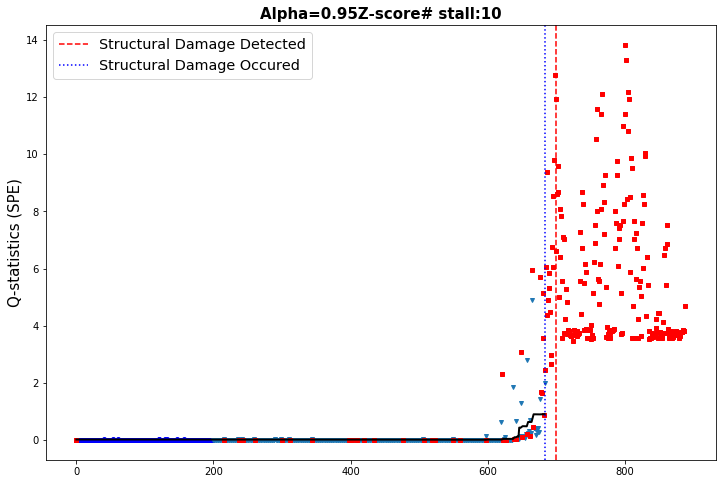

In [15]:
%matplotlib inline

fig = plt.figure(figsize=(12, 8))
plt.plot(x0, Q['Qdist'][x0], 'bo', linewidth=2, markersize=4)
plt.plot(x1, Q['Qdist'][x1], 'v', linewidth=2, markersize=4)

IND_abnor = np.argwhere(PC['Updated']==0)
IND_nor = np.argwhere(PC['Updated']==1)
plt.plot(IND_abnor,Q['Qdist'][IND_abnor],'rs',linewidth=2, markersize=4) # Outlier and faulty samples
plt.plot(IND_nor,Q['distcrit'][IND_nor][:,:, 0],'k-',linewidth=2, markersize=4) # Outlier and faulty samples
plt.axvline(x = PCA_par['d_indx'][0], color = 'red', linestyle ='--', label='Structural Damage Detected')
plt.axvline(x = IND_nor[-1, 0], color = 'blue', linestyle =':', label='Structural Damage Occured')
plt.ylabel('Q-statistics (SPE)',fontsize=15)
plt.title('Alpha='+str(alpha)+str(SD_type)+'# stall:'+str(PCA_par['n_stall']),fontsize=15,fontweight='bold')
plt.legend(fontsize='x-large')
plt.show